![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQd4QydQ73_Hw70QbQzvSV-Z19tfuAPIk9Ts1wAOJImxc2383vC)


This notebook will deal with some interesting analysis of whatsapp group messages. I have choosen my University whatsapp group. 
Datasource: You can extract messages from whatsapp to a .txt file.

### Plan of action
- Clean and sanitize the data.
- Vizualize data to produce some interesting insights.

### Importing libraries

In [1]:
import pandas as pd
import re
import os
import emoji
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

### Data pre-processing

In [2]:
file_path = r'C:\\Users\\heman\\Desktop\\Projects\\Github\\Whatsapp chat\\UB MIS20.txt'

if os.path.exists(file_path):
    file_data = open(file_path,'r', encoding="utf8")
    whatsapp_content = file_data.read()

useful_lines = []
for line in whatsapp_content.split("\n"):
    count = len(re.findall(":", line))
    if count>=2:  #removing junk lines which are not texts
        useful_lines.append(line)
useful_str = "\n".join(useful_lines)

### Data extraction

In [3]:
# Get date
date_regex=re.compile(r'(\d+/\d+/\d+)')
date=date_regex.findall(useful_str)
date = [x.strip() for x in date]

# Get time
time_regex=re.compile(r'(\d{1,2}:\d{2})')
time=time_regex.findall(useful_str)
time = [x.strip() for x in time]

# Get Users
user_regex=re.compile(r'-(.*?):')
user=user_regex.findall(useful_str)
user = [x.strip() for x in user]

# Get Message
message_regex=re.compile(r'([^:]+):?$')
me_regex=re.compile(r"(\n)(?<=)(\d+/\d+/\d+)(.*)")
mess=me_regex.findall(useful_str)
message = [''.join(message_regex.findall(''.join(msg))).strip() for msg in mess]
message = [x.strip() for x in message]

In [4]:
data = []
for w,x,y,z in zip(date,time,user,message):
    data.append([str(w),str(x),str(y),str(z)])

In [5]:
df=pd.DataFrame(data,columns=("Date","Time","User","Message"))

### Sanitizing the data

In [6]:
# Get Year from Date
df['Date'] = pd.to_datetime(df['Date'])
df['Year']=df['Date'].dt.year

# Get Month from Date
df['Month']=df['Date'].dt.month

# Get Day from Date
df['Day']=df['Date'].dt.day

# Message words
df['Words'] = df['Message'].str.strip().str.split('[\W_]+')

# Word length
df['Word Length'] = df['Words'].apply(len)-2

# Get the Length of Message
df['Message Characters'] = df['Message'].map(str).apply(len)-3

# Get Media shared in the Message
df['Media']=df['Message'].str.contains('<Media omitted>')

#loading clean data into a file
df.to_csv("whatsapp.csv")

In [7]:
data = pd.read_csv('whatsapp.csv')

### Emojicons extraction

In [8]:
#Emoji extraction
emojis = {'emj':[],'count':[],'user':[]}
def extract_emojis(string,user):
    emj = []
    for c in string:
        if c in emoji.UNICODE_EMOJI:
            emj.append(c)

    if len(emj) > 0:
        groups = Counter(emj)
        for c in groups.items():
            emojis["emj"].append(c[0])
            emojis["count"].append(c[1])
            emojis["user"].append(user)

for i in range(len(data)):
    extract_emojis(str(data.Message[i]),data.User[i])

In [9]:
#removing emojis and non alphabetic characters from the set.
def remove_all(string):
    string = str(string)
    msg_ = re.sub("[^a-zA-Z]", " ", string)
    tokens = word_tokenize(msg_)[:]
    result = [word for word in tokens if word.lower() not in stopwords.words('english')]    
    return ' '.join(result)

In [10]:
data['Message'] = data['Message'].astype('object')
data['CleanMessage'] = data['Message'].apply(remove_all)

### Creating word map with WordCloud API

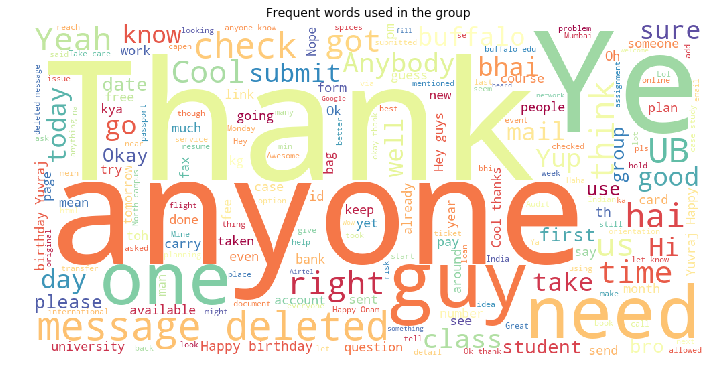

In [11]:
chat_words = ' '.join(data['CleanMessage'])
chat_words = chat_words.replace('Media omitted', '')

wordcloud = WordCloud(
        width = 1000, 
        height = 500,
        background_color = "white",
        random_state=42,
        max_words=200,
        colormap='Spectral'
    ).generate(chat_words)

plt.figure(figsize=(12,10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title('Frequent words used in the group')
plt.show()

### Interesting Insights

In [12]:
%%html
<div class='tableauPlaceholder' id='viz1569921378382' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;QD&#47;QDG7HT54K&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='path' value='shared&#47;QDG7HT54K' /> <param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;QD&#47;QDG7HT54K&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1569921378382');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='1000px';vizElement.style.height='827px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='1000px';vizElement.style.height='827px';} else { vizElement.style.width='100%';vizElement.style.height='727px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

[Check it out on tableau public](https://public.tableau.com/profile/hemanth.devarapati#!/vizhome/WhatsappChatAnalysis_15699181210580/Dashboard1)

### Most used emojicons

In [13]:
pd.DataFrame(emojis).groupby(['emj']).sum().sort_values(by=['count'],ascending=False)

,count
emj,
😂,323
🏻,235
👍,233
🤣,154
😅,93
🏼,84
😊,62
😝,38
🥳,35


### Most used emojicon by user

In [14]:
pd.DataFrame(emojis).groupby(['user','emj']).sum().sort_values(by=['count'],ascending=False)

,,count
user,emj,
+1 (716) 398-6986,😂,31
+91 95450 58123,😂,20
Ashish Ub Mis,👍,18
Rahul Ub Mis,😂,16
+91 95450 58123,🏻,15
+91 88677 33583,😂,15
Ashish Ub Mis,🏻,14
+1 (716) 544-7946,😂,14
Ashish Ub Mis,😂,14


### People with highest word length in a message

In [30]:
data.sort_values(by=['Word Length'],ascending=False)['User'][:10]

2295          Ojas Ub Mis
3245    +1 (716) 479-0835
2149    +1 (716) 544-7946
3470    +1 (716) 400-1246
1471      +91 72620 32588
4019    +1 (716) 507-9515
4227    +1 (716) 507-9515
3136      +91 95450 58123
2718      +91 72760 96888
2714      +91 99157 19527
Name: User, dtype: object